In this kernel we're going to train a word2vec embedding for bigrams using Gensim and then plot the results in 3d using PCA and t-SNE

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['googleplaystore.csv', 'googleplaystore_user_reviews.csv', 'sample_submission_stage_1.csv', 'SW_EpisodeIV.txt', 'SW_EpisodeV.txt', 'SW_EpisodeVI.txt', 'test_stage_1.tsv']


In [2]:
import string
import gensim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
matplotlib.style.use('ggplot')

%matplotlib inline

In [3]:
df_IV = pd.read_table("../input/SW_EpisodeIV.txt", error_bad_lines=False, delim_whitespace=True, header=0, escapechar='\\')
df_V = pd.read_table("../input/SW_EpisodeV.txt", error_bad_lines=False, delim_whitespace=True, header=0, escapechar='\\')
df_VI = pd.read_table("../input/SW_EpisodeVI.txt", error_bad_lines=False, delim_whitespace=True, header=0, escapechar='\\')

pd.set_option('display.max_colwidth', -1)
df_IV.columns = ['speaker','text']
df_V.columns = ['speaker', 'text']
df_VI.columns = ['speaker', 'text']

In [4]:
df_IV.head(4)

,speaker,text
1,THREEPIO,Did you hear that? They've shut down the main reactor. We'll be destroyed for sure. This is madness!
2,THREEPIO,We're doomed!
3,THREEPIO,There'll be no escape for the Princess this time.
4,THREEPIO,What's that?


In [9]:
def prep_text(in_text):
    return in_text.lower().translate(str.maketrans("", "", string.punctuation)).split()

First let's prep the data

In [10]:
df_IV['clean_text'] = df_IV.apply(lambda row: prep_text(row['text']), axis=1)
df_V['clean_text'] = df_V.apply(lambda row: prep_text(row['text']), axis=1)
df_VI['clean_text'] = df_VI.apply(lambda row: prep_text(row['text']), axis=1)
df_IV.head(5)

,speaker,text,clean_text
1,THREEPIO,Did you hear that? They've shut down the main reactor. We'll be destroyed for sure. This is madness!,"[did, you, hear, that, theyve, shut, down, the, main, reactor, well, be, destroyed, for, sure, this, is, madness]"
2,THREEPIO,We're doomed!,"[were, doomed]"
3,THREEPIO,There'll be no escape for the Princess this time.,"[therell, be, no, escape, for, the, princess, this, time]"
4,THREEPIO,What's that?,"[whats, that]"
5,THREEPIO,I should have known better than to trust the logic of a half-sized thermocapsulary dehousing assister...,"[i, should, have, known, better, than, to, trust, the, logic, of, a, halfsized, thermocapsulary, dehousing, assister]"


and use that to create a large corpus for training

In [11]:
df = pd.concat([df_IV, df_V, df_VI])

sentences = []
for idx, row in df.iterrows():
    sentences.append(row['clean_text'])

df.head(5)

,speaker,text,clean_text
1,THREEPIO,Did you hear that? They've shut down the main reactor. We'll be destroyed for sure. This is madness!,"[did, you, hear, that, theyve, shut, down, the, main, reactor, well, be, destroyed, for, sure, this, is, madness]"
2,THREEPIO,We're doomed!,"[were, doomed]"
3,THREEPIO,There'll be no escape for the Princess this time.,"[therell, be, no, escape, for, the, princess, this, time]"
4,THREEPIO,What's that?,"[whats, that]"
5,THREEPIO,I should have known better than to trust the logic of a half-sized thermocapsulary dehousing assister...,"[i, should, have, known, better, than, to, trust, the, logic, of, a, halfsized, thermocapsulary, dehousing, assister]"


Now we can use [gensim's phrases](https://radimrehurek.com/gensim/models/phrases.html#module-gensim.models.phrases) to find bigrams

In [12]:
from gensim.models import phrases, word2vec

bigrams = phrases.Phrases(sentences)

In [13]:
print(bigrams["this is the death star".split()])

['this', 'is', 'the', 'death_star']


as you can see, "death star" has been recognised as a bi-gram (indicated by the `_`)

This gives us something to train a w2v model over. There are a couple of important hyperparameters with gensim you need to think about when training a w2v model (I'm not convinced the defaults are great..):

- size: this is the dimensionality of the vector space. The rule of thumb here is more dimensions requires more data and time to train, but also can pick up more information about the way words are used. It's typical to see this somewhere in the range of 50 to 300. We don't have that much text here so lets go with just 50
- min_count: the min number of times a word appears before it's included in the output. 3 is perfectly ok given the size of this corpus
- iter: this is often overlooked. You can think of it as epochs. The default is 5, which feels very small

In [40]:
bigrams[sentences]

model = word2vec.Word2Vec(bigrams[sentences], size=30, min_count=3, iter=20)

In [41]:
model.wv.most_similar('death_star')

[('rebel', 0.9991886615753174),
 ('alliance', 0.998733639717102),
 ('galaxy', 0.9986464381217957),
 ('systems', 0.9986209273338318),
 ('battle_station', 0.9985862970352173),
 ('control', 0.998578667640686),
 ('operational', 0.9985567927360535),
 ('other', 0.9984045624732971),
 ('patience', 0.9983667731285095),
 ('star', 0.9983597993850708)]

## plotting it

So let's plot it!

We're going to use dimensionality reduction to reduce the number of dimensions down from 50 to 3. Specifally we're going to use PCA and t-SNE

First we need the words in the embedding

In [42]:
vocab = list(model.wv.vocab)
len(vocab)

1108

1108 is probably too many words to display nicely in a plot - we will thin this down a bit soon.

We need to now find the vector representing each word, we can do this like so

In [43]:
X = model[vocab]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


Lets train PCA over that

In [44]:
pca = PCA(n_components=3, random_state=11, whiten=True)
clf = pca.fit_transform(X)

tmp = pd.DataFrame(clf, index=vocab, columns=['x', 'y', 'z'])

tmp.head(3)

,x,y,z
did,1.061120,-4.780354,-1.509090
you,1.677801,-5.010963,-3.611207
hear,0.741069,-0.999855,0.090091


I'm now going to take a random sample of words from the vocab, just 150. Another way to thin this down might be to only pick nouns or only pick the most common words

In [45]:
tmp = tmp.sample(150)

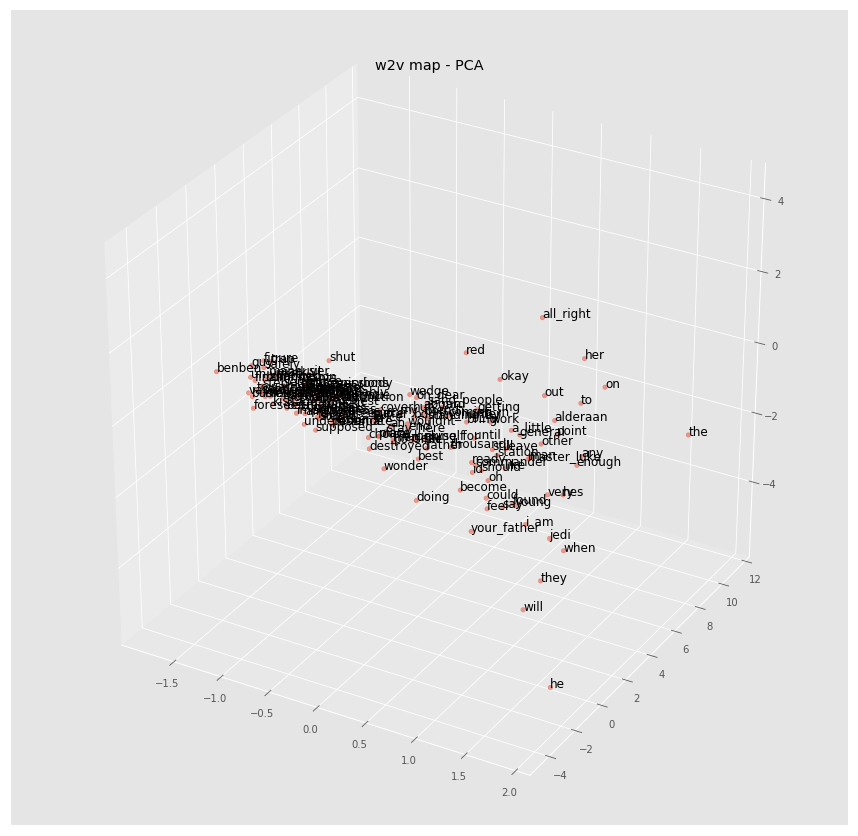

In [46]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(tmp['x'], tmp['y'], tmp['z'], alpha = 0.5)

for word, row in tmp.iterrows():
    x, y, z = row
    pos = (x, y, z)
    ax.text(x, y, z, s=word, size=12, zorder=1, color='k')
    
plt.title('w2v map - PCA')
plt.show()

Lets print the same thing with t-SNE

In [47]:
tsne = TSNE(n_components=3, random_state=11)
clf = tsne.fit_transform(X)

tmp = pd.DataFrame(clf, index=vocab, columns=['x', 'y', 'z'])

tmp.head(3)

,x,y,z
did,6.352072,-5.745885,-1.891505
you,6.297225,-5.142827,-5.129514
hear,5.060881,-5.169820,4.778052


In [48]:
tmp = tmp.sample(150)

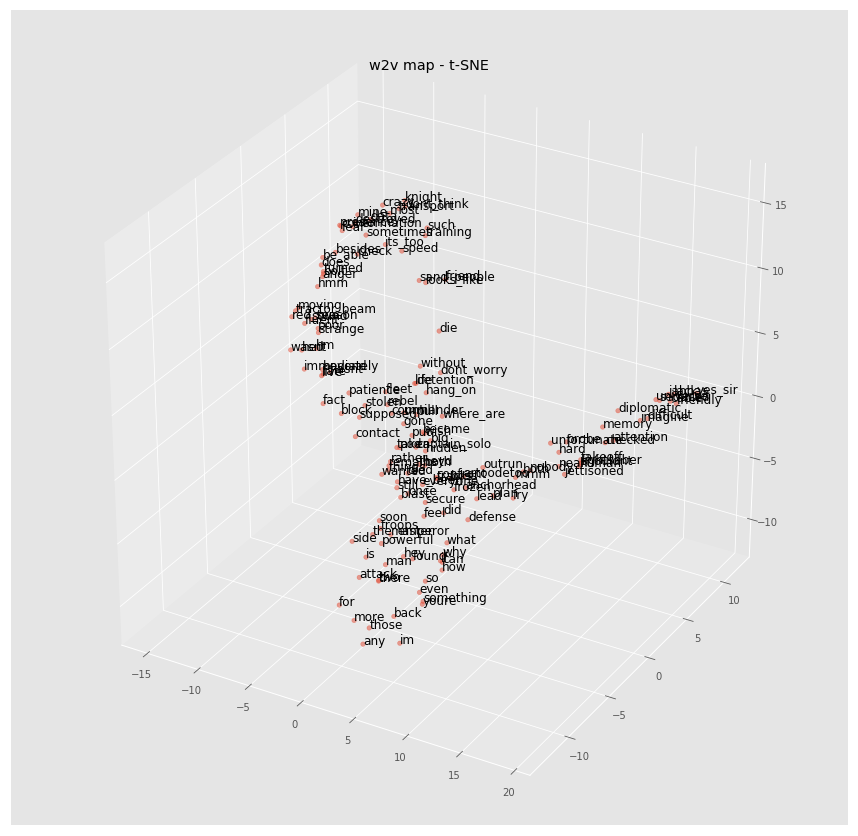

In [49]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(tmp['x'], tmp['y'], tmp['z'], alpha = 0.5)

for word, row in tmp.iterrows():
    x, y, z = row
    pos = (x, y, z)
    ax.text(x, y, z, s=word, size=12, zorder=1, color='k')
    
plt.title('w2v map - t-SNE')
plt.show()